# STEP 1 - DATASET SELECTION

We selected the CREMA-D and RAVDESS speech emotion recognition datasets. Combined, they provide over 12,000 labeled audio clips across six shared emotion categories (neutral, happy, sad, angry, fear, disgust). This satisfies the ≥ 5,000 record requirement. The datasets require significant cleaning — aligning sampling rates, normalizing loudness, trimming/padding durations, and unifying emotion labels — making them suitable for a comprehensive ML workflow with both RNN and traditional ML models.”

# STEP 2 - DATA CLEANING

Goal of this step are :

      Make both datasets have the same format

      Same sample rate (16 kHz)

      Mono channel

      Fixed duration (e.g., 3 seconds)

      Same label set (6 emotions) where we dropped calm (02) and surprise (08) from RAVDESS and dropped anything not in these 6 from CREMA-D.

      Remove any corrupted files or mismatched labels.

      Prepare clean features for both traditional ML and RNN models.






1 - LABEL ALIGNMENT

**RAVDESS** codes → map numeric IDs from filename:

01 = neutral

03 = happy

04 = sad

05 = angry

06 = fear

07 = disgust

(Drop 02 = calm, 08 = surprise)

**CREMA-D** labels → already short codes in metadata:

NEU = neutral

HAP = happy

SAD = sad

ANG = angry

FEA = fear

DIS = disgust

**2 - Audio standardization**

For both datasets:

Resample to 16 kHz.

Convert to mono.

Normalize waveform amplitude (z-score or peak normalize).

Trim/pad to exactly 3 seconds:

Trim excess from the end.

Pad with zeros (silence) if too short.

In [11]:
# STEP 2: DATA CLEANING
# RAVDESS + CREMA-D


import os
import librosa
import numpy as np
import tensorflow_datasets as tfds


# CONFIG

SR = 16000        # target sample rate
DURATION = 3      # seconds
SAMPLES = SR * DURATION

# Emotion mappings

RAVDESS_MAP = {
    '01': 'neutral',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fear',
    '07': 'disgust'
}
CREMA_MAP = {
    'NEU': 'neutral',
    'HAP': 'happy',
    'SAD': 'sad',
    'ANG': 'angry',
    'FEA': 'fear',
    'DIS': 'disgust'
}


# CLEANING FUNCTION

def clean_audio(y):
    """Normalize and fix audio to exactly 3 seconds."""
    y = librosa.util.normalize(y)
    if len(y) < SAMPLES:
        y = np.pad(y, (0, SAMPLES - len(y)))   # pad with silence
    else:
        y = y[:SAMPLES]                        # trim
    return y


# LOAD + CLEAN RAVDESS

def load_ravdess(ravdess_dir):
    data = []
    for root, _, files in os.walk(ravdess_dir):
        for file in files:
            if not file.lower().endswith('.wav'):
                continue
            parts = file.split('-')
            emo_code = parts[2]  # emotion code in filename
            if emo_code in RAVDESS_MAP:
                label = RAVDESS_MAP[emo_code]
                y, _ = librosa.load(os.path.join(root, file), sr=SR, mono=True)
                y = clean_audio(y)
                data.append((y, label))
    return data


# LOAD + CLEAN CREMA-D

def load_cremad():
    data = []
    ds_splits = ['train', 'validation', 'test']
    for split in ds_splits:
        ds = tfds.load('crema_d', split=split, as_supervised=True)
        for audio, label in tfds.as_numpy(ds):
            label_str = list(CREMA_MAP.values())[label]  # map numeric to string
            y = librosa.resample(audio.astype(np.float32), orig_sr=44100, target_sr=SR)
            y = clean_audio(y)
            data.append((y, label_str))
    return data


# RUN IN COLAB

from google.colab import drive
drive.mount('/content/drive')

# Path to the RAVDESS folder in Drive

ravdess_path = "/content/drive/MyDrive/NN PROJECT/Audio_Speech_Actors_01-24"

# Load & clean both datasets
ravdess_data = load_ravdess(ravdess_path)
cremad_data = load_cremad()

print(f"RAVDESS cleaned clips: {len(ravdess_data)}")
print(f"CREMA-D cleaned clips: {len(cremad_data)}")

#Combine datasets

all_data = ravdess_data + cremad_data
print(f"Total cleaned clips: {len(all_data)}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/crema_d/incomplete.FOWXR8_1.0.0/crema_d-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/crema_d/incomplete.FOWXR8_1.0.0/crema_d-validation.tfrecord*...:   0%|    …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/crema_d/incomplete.FOWXR8_1.0.0/crema_d-test.tfrecord*...:   0%|          …

Dataset crema_d downloaded and prepared to /root/tensorflow_datasets/crema_d/1.0.0. Subsequent calls will reuse this data.
RAVDESS cleaned clips: 1056
CREMA-D cleaned clips: 7438
Total cleaned clips: 8494


In [20]:
# Mapping for CREMA-D short codes

crema_map = {
    "HAP": "happy",
    "SAD": "sad",
    "ANG": "angry",
    "NEU": "neutral",
    "DIS": "disgust",
    "FEA": "fear"
}

# Function to map labels
def unify_labels(dataset, source):
    unified = []
    for audio, label in dataset:
        if source == "crema":
            label = crema_map.get(label, label)  # map short codes
        elif source == "ravdess":
            label = label.lower()  # ensure lowercase
        unified.append((audio, label))
    return unified

# Apply mapping
ravdess_data = unify_labels(ravdess_data, "ravdess")
cremad_data = unify_labels(cremad_data, "crema")

# Combine again
all_data = ravdess_data + cremad_data


# STEP 3 - EDA for RAVDESS + CREMA-D

## Checking the Target Distribution

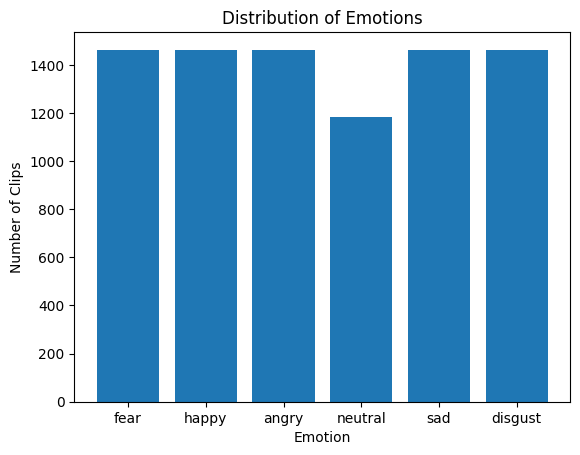

Counter({'happy': 1463, 'angry': 1463, 'fear': 1462, 'sad': 1462, 'disgust': 1462, 'neutral': 1182})


In [19]:
# Normalize all labels to lowercase and standard naming before EDA

from collections import Counter

# Normalize labels
normalized_data = [(clip, label.strip().lower()) for clip, label in all_data]

# Count labels
emotion_counts = Counter([label for _, label in normalized_data])

# Plot
plt.bar(emotion_counts.keys(), emotion_counts.values())
plt.xlabel('Emotion')
plt.ylabel('Number of Clips')
plt.title('Distribution of Emotions')
plt.show()

print(emotion_counts)


##  EDA 1 - Waveform & Spectrogram per Emotion

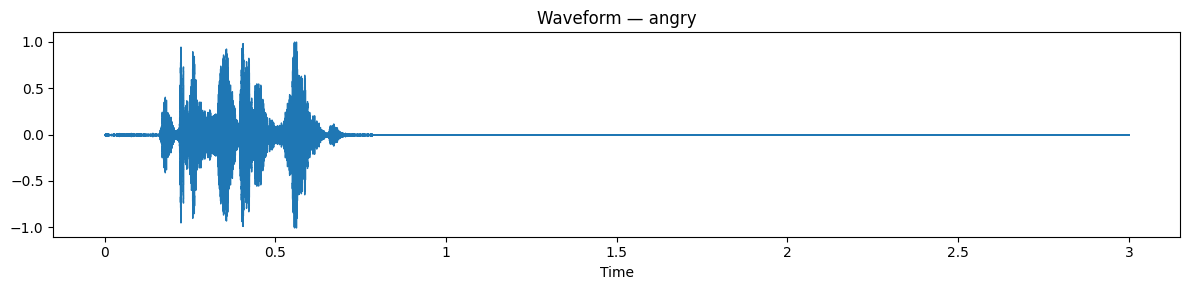

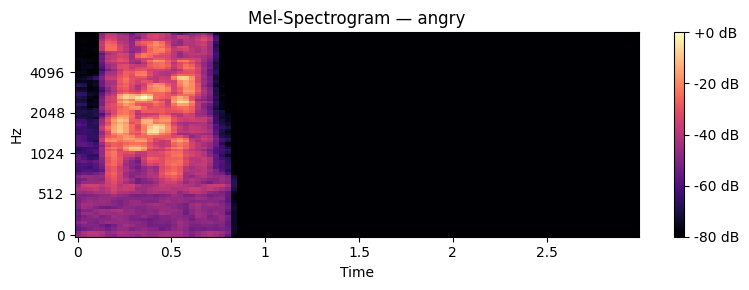

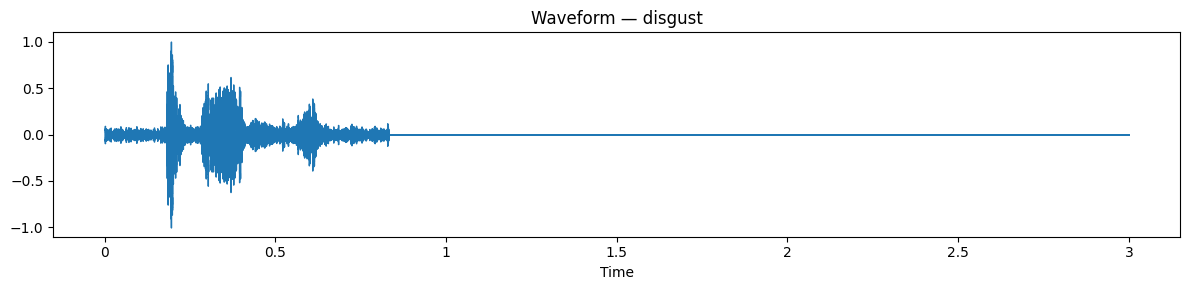

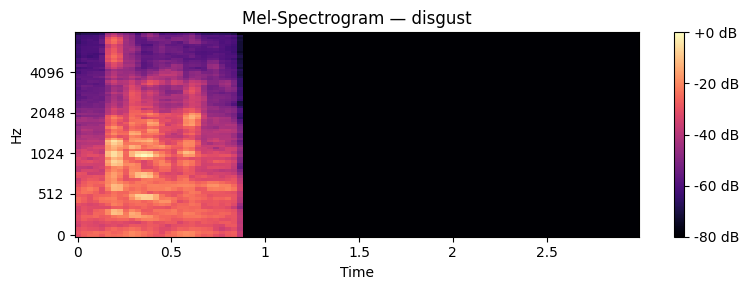

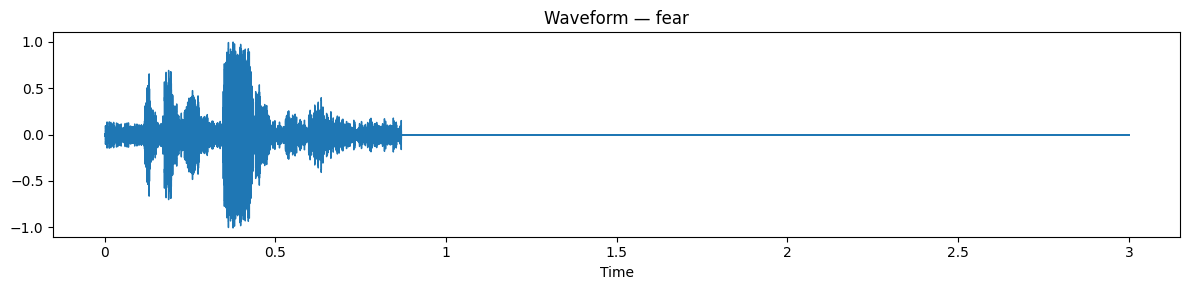

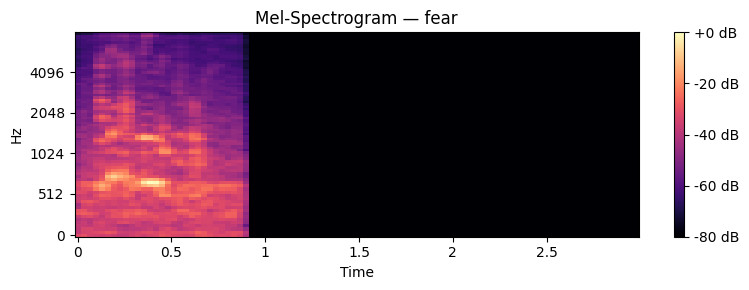

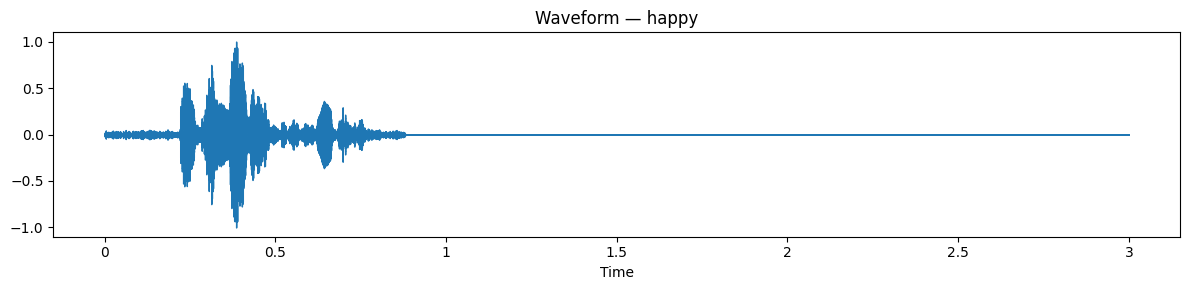

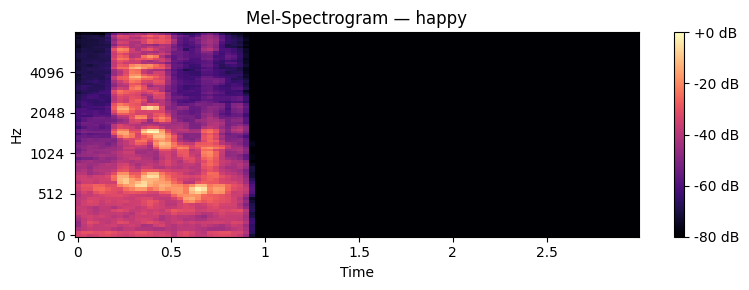

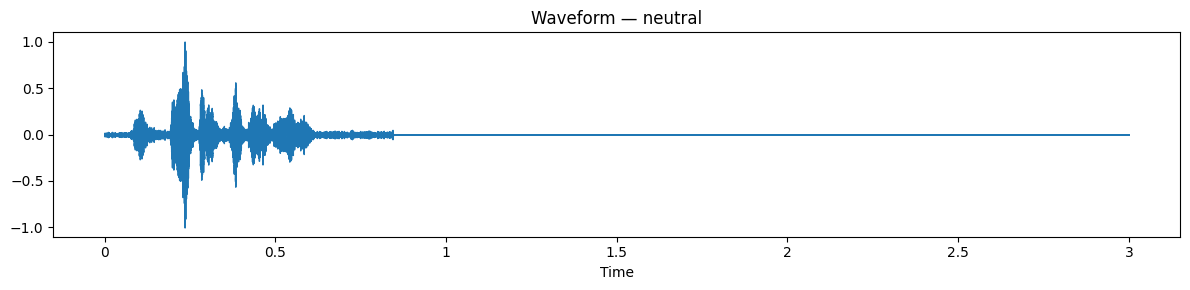

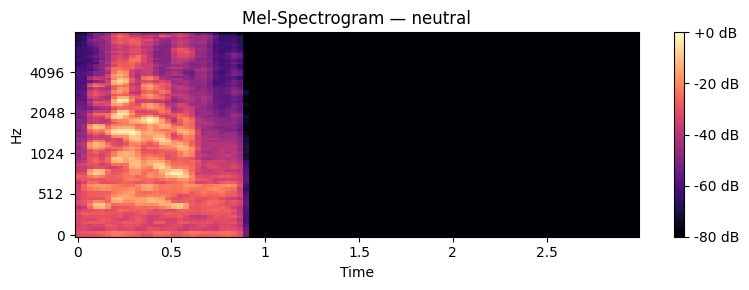

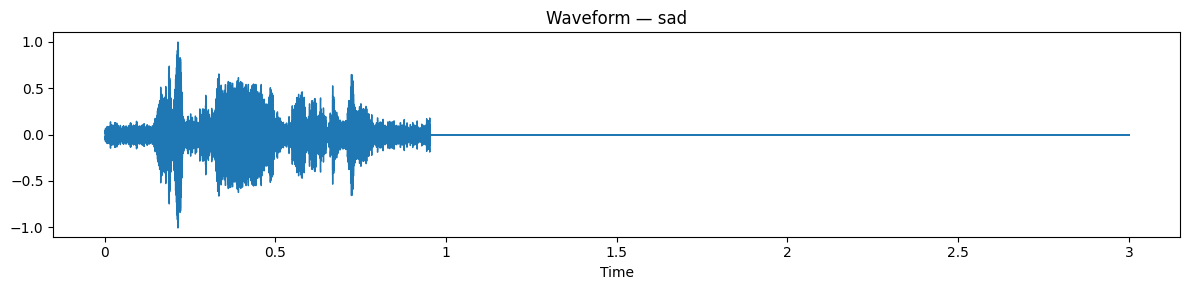

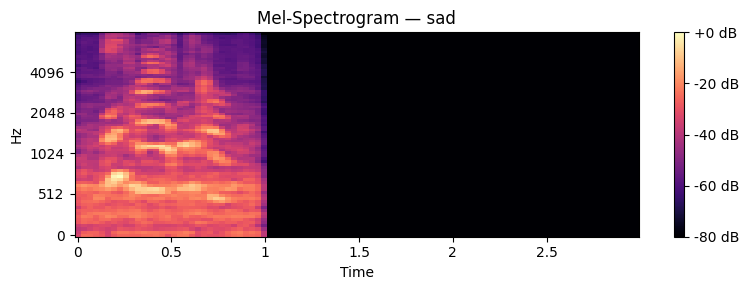

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa, librosa.display
from collections import Counter
import random

SR = 16000  # same as in cleaning

# Build a DataFrame from (audio_array, label)
df = pd.DataFrame(all_data, columns=["audio", "emotion"])


# One waveform + mel-spectrogram per emotion
emotions = sorted(df["emotion"].unique())
for emo in emotions:
    y = df[df["emotion"] == emo].sample(1, random_state=0)["audio"].values[0]  # this is already a NumPy array

    plt.figure(figsize=(12,3))
    librosa.display.waveshow(y, sr=SR)
    plt.title(f"Waveform — {emo}")
    plt.tight_layout(); plt.show()

    S = librosa.feature.melspectrogram(y=y, sr=SR, n_mels=80)
    S_db = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(8,3))
    librosa.display.specshow(S_db, sr=SR, x_axis="time", y_axis="mel")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Mel-Spectrogram — {emo}")
    plt.tight_layout(); plt.show()


## EDA 2- Audio Duration Distribution

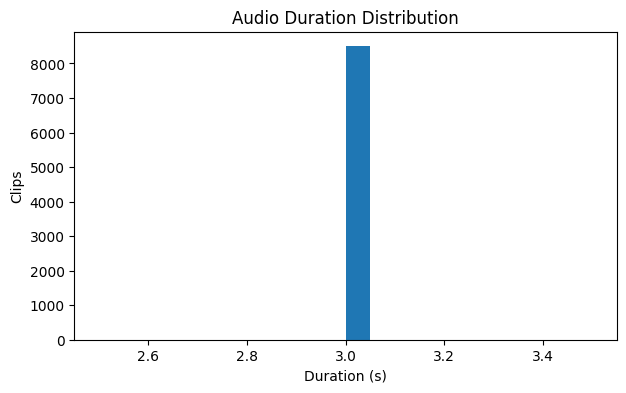

Min: 3.00s | Max: 3.00s | Mean: 3.00s


In [29]:
# Duration check (should be ~3.0s after cleaning)
durations = [len(a)/SR for a in df["audio"]]
plt.figure(figsize=(7,4))
plt.hist(durations, bins=20)
plt.xlabel("Duration (s)"); plt.ylabel("Clips"); plt.title("Audio Duration Distribution")
plt.show()
print(f"Min: {np.min(durations):.2f}s | Max: {np.max(durations):.2f}s | Mean: {np.mean(durations):.2f}s")


# STEP 4 -  FEATURE EXTRACTION

Taking raw data (audio, images, text) and automatically deriving numeric representations that models can understand.

In [30]:

# MFCC FEATURE EXTRACTION (Tabular for ML)

import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder

SR = 16000          # must match your cleaning step
N_MFCC = 20         # 20 MFCCs is standard
USE_DELTAS = True   # include Δ and ΔΔ
AGG_FUNCS = ("mean","std","min","max")  # aggregate over time

def mfcc_stats_from_audio(y, sr=SR, n_mfcc=N_MFCC, use_deltas=USE_DELTAS):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    feats = [mfcc]
    if use_deltas:
        d1 = librosa.feature.delta(mfcc)
        d2 = librosa.feature.delta(mfcc, order=2)
        feats += [d1, d2]
    F = np.concatenate(feats, axis=0)   # shape: (n_feats, T)

    # aggregate over time to get a fixed-length vector
    stats = []
    if "mean" in AGG_FUNCS: stats.append(F.mean(axis=1))
    if "std"  in AGG_FUNCS: stats.append(F.std(axis=1))
    if "min"  in AGG_FUNCS: stats.append(F.min(axis=1))
    if "max"  in AGG_FUNCS: stats.append(F.max(axis=1))
    return np.concatenate(stats, axis=0).astype(np.float32)  # shape: n_feats * len(AGG_FUNCS)

# ---------- Build X, y from your cleaned all_data ----------
# all_data must be: [(audio_array, label_str), ...]
labels = [lbl for _, lbl in all_data]
le = LabelEncoder().fit(labels)

X_list, y_list = [], []
for y_audio, lbl in all_data:
    x_vec = mfcc_stats_from_audio(y_audio, sr=SR)
    X_list.append(x_vec)
    y_list.append(le.transform([lbl])[0])

X = np.vstack(X_list).astype(np.float32)
y = np.array(y_list, dtype=np.int64)

print("X shape:", X.shape)  # e.g., (N, 60 * 4 = 240) when N_MFCC=20 and Δ/ΔΔ on, 4 aggregations
print("y shape:", y.shape)
print("Classes:", list(le.classes_))

# Optional: save for reuse
np.save("X_mfcc_stats.npy", X)
np.save("y_labels.npy", y)
import joblib; joblib.dump(le, "label_encoder.joblib")


X shape: (8494, 240)
y shape: (8494,)
Classes: [np.str_('angry'), np.str_('disgust'), np.str_('fear'), np.str_('happy'), np.str_('neutral'), np.str_('sad')]


['label_encoder.joblib']

# TRAIN AND EVALUATE using Baseline Models

=== Baseline Summary (test set) ===
       Model Accuracy Macro-F1
     XGBoost    0.536    0.531
   SVM (RBF)    0.531    0.526
RandomForest    0.501    0.489
  Linear SVM    0.481    0.474

=== Per-class F1 (test set) ===
Model   Linear SVM RandomForest SVM (RBF) XGBoost
Emotion                                          
angry        0.634        0.655     0.662   0.689
disgust      0.449        0.412     0.486   0.480
fear         0.403        0.384     0.444   0.450
happy        0.398        0.465     0.467   0.476
neutral      0.446        0.449     0.544   0.525
sad          0.517        0.568     0.550   0.566


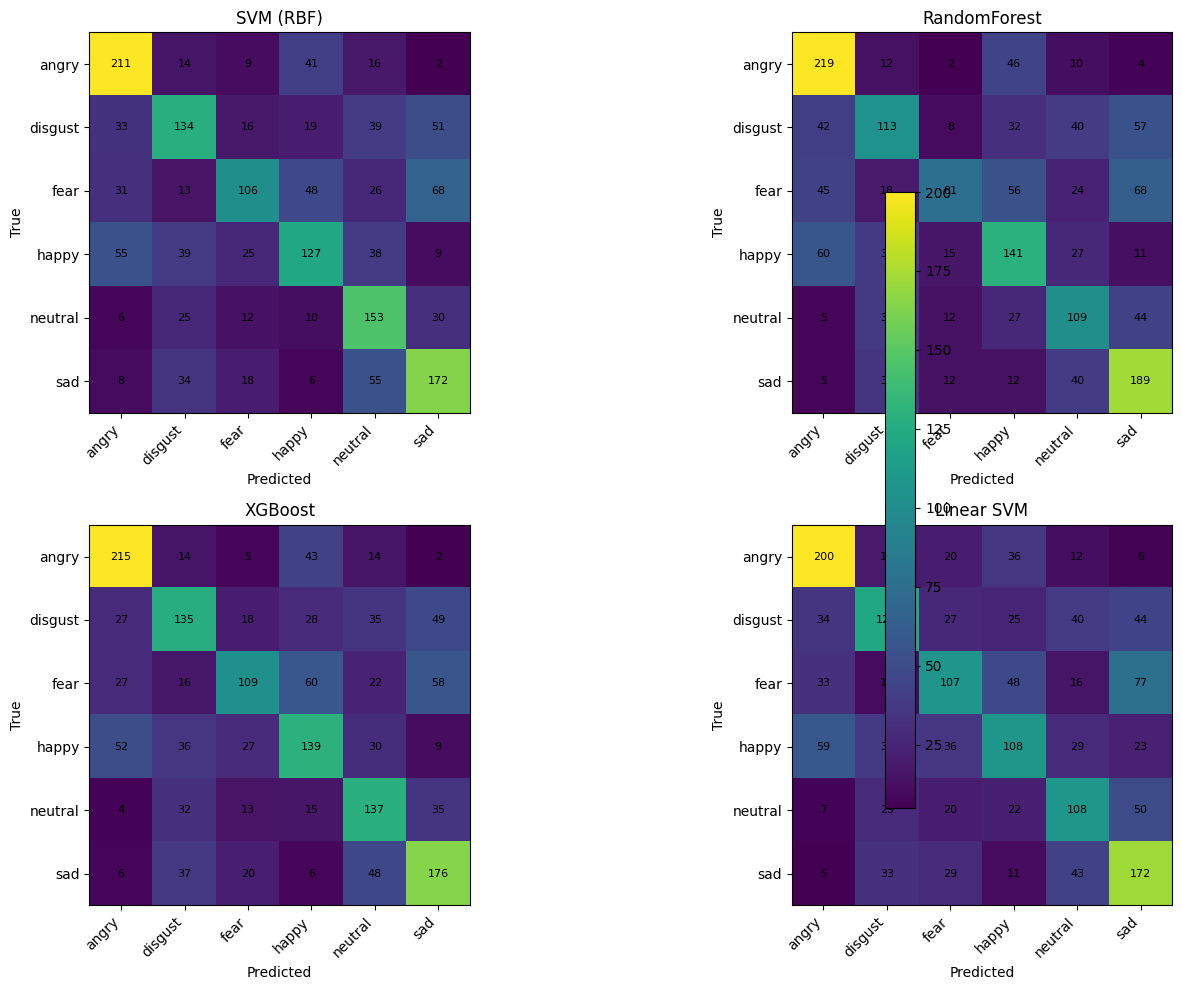

['label_encoder.joblib']

In [39]:
# Baselines with Scaling: SVM (RBF), Random Forest, XGBoost, Linear SVM


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
import joblib
import warnings

warnings.filterwarnings("ignore")

# 1) Split once and reuse
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
class_names = list(le.classes_)

# 2) Define models (each with scaling where relevant)
svm_rbf = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("svm", SVC(kernel="rbf", C=1.0, gamma="scale", class_weight="balanced",
                probability=True, random_state=42)),
])

rf = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),  # harmless for trees; keeps preprocessing uniform
    ("rf", RandomForestClassifier(
        n_estimators=300, max_depth=None, max_features="sqrt",
        min_samples_split=2, min_samples_leaf=1,
        class_weight="balanced", n_jobs=-1, random_state=42
    ))
])

# device choice for XGBoost
device = "cpu"
try:
    import torch
    if torch.cuda.is_available(): device = "cuda"
except Exception:
    pass

xgb_core = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(class_names),
    eval_metric='mlogloss',
    n_estimators=300,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method='hist',
    device=device,
    predictor='auto',
    random_state=42,
)
xgb_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("xgb", xgb_core)
])

linear_svm = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("linsvm", LinearSVC(C=1.0, max_iter=5000, random_state=42))
])

models = {
    "SVM (RBF)": svm_rbf,
    "RandomForest": rf,
    "XGBoost": xgb_pipe,
    "Linear SVM": linear_svm,
}

# 3) Train/evaluate/collect
summary_rows, per_class_records, cms = [], [], {}
for name, model in models.items():
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    acc = accuracy_score(y_te, y_pred)
    macro_f1 = f1_score(y_te, y_pred, average="macro")
    report = classification_report(y_te, y_pred, target_names=class_names, output_dict=True, zero_division=0)

    summary_rows.append({"Model": name, "Accuracy": acc, "Macro-F1": macro_f1})
    for cls in class_names:
        per_class_records.append({"Emotion": cls, "Model": name, "F1": report[cls]["f1-score"]})

    cms[name] = confusion_matrix(y_te, y_pred)

    out_name = name.lower().replace(" ", "_").replace("(", "").replace(")", "")
    joblib.dump(model, f"{out_name}.pkl")

# 4) Summary tables
summary_df = pd.DataFrame(summary_rows).sort_values("Macro-F1", ascending=False).reset_index(drop=True)
summary_df["Accuracy"] = summary_df["Accuracy"].map(lambda v: f"{v:.3f}")
summary_df["Macro-F1"] = summary_df["Macro-F1"].map(lambda v: f"{v:.3f}")
print("=== Baseline Summary (test set) ===")
print(summary_df.to_string(index=False))

per_class_df = pd.DataFrame(per_class_records).pivot(index="Emotion", columns="Model", values="F1").reindex(index=class_names)
per_class_df = per_class_df.applymap(lambda v: f"{v:.3f}")
print("\n=== Per-class F1 (test set) ===")
print(per_class_df.to_string())

# 5) Confusion matrices: 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()
for ax, (name, cm) in zip(axes, cms.items()):
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticklabels(class_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha='center', va='center', fontsize=8)
fig.colorbar(im, ax=axes.tolist(), shrink=0.8)
plt.tight_layout()
plt.show()

# 6) Save label encoder
joblib.dump(le, "label_encoder.joblib")


# Save the best model - XGBoost

In [40]:
import joblib, json

# If your dict was models = {"XGBoost": xgb_pipe, ...}
best_model = models["XGBoost"]   # already fitted Pipeline(scaler -> XGB)
joblib.dump(best_model, "xgb_pipeline.pkl")

# Save label encoder and class names (order matters for reports/UI)
joblib.dump(le, "label_encoder.joblib")
with open("classes.json", "w") as f:
    json.dump(list(le.classes_), f)

print("Saved: xgb_pipeline.pkl, label_encoder.joblib, classes.json")


Saved: xgb_pipeline.pkl, label_encoder.joblib, classes.json
